In [1]:
import os
import keras
import keras.backend as K
import numpy as np
import tensorflow as tf
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model

from data import read_crop_list, load_structured_sample
from eval import eval_model_one_hot
from metrics import f1, f1_loss
from models import model_stack_lstm, model_Conv1D, model_Conv1D_LSTM
from training import train, create_training_folder
from keras.utils import plot_model
from training import train, create_training_folder, create_callbacks, step_decay_exp


from keras.models import Sequential
from tensorflow.python.keras.layers import Embedding, LSTM, BatchNormalization, Dense, Conv1D, GlobalAveragePooling1D, \
    Dropout, Input, Permute, Concatenate, Activation, Flatten

from training import train, create_training_folder


In [2]:
def load_model(file_name):
    loaded_model = keras.models.load_model(file_name)
    return loaded_model

In [3]:
from training import train, create_training_folder

tf.keras.utils.get_custom_objects()
tf.keras.utils.get_custom_objects()['f1'] = f1
tf.keras.utils.get_custom_objects()['f1_loss'] = f1_loss

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [4]:
from sklearn.preprocessing import OneHotEncoder
def one_hot_enc(X, y):
    categories = categories = np.unique(y).tolist()
    enc = OneHotEncoder(categories = [categories], sparse=False)
    yf = enc.fit_transform(y.reshape([-1,1]))
    enc = OneHotEncoder(categories = [categories]*8, sparse=False)
    Xf = enc.fit_transform(X)
    return Xf, yf

In [5]:
# Xt, yt = one_hot_enc(X, y)

# Xt



In [6]:

df_crops, vocab = read_crop_list()

sample = load_structured_sample()
# sample = load_undersampled_data()
print("Using sample size: {}".format(sample.shape))

y = sample[:, 11]
X = sample[:, 1:11]
sequence_length = X.shape[-1]

# X = one_hot_encoding_X(X, vocab_size=vocab_size)
# y = to_categorical(y)

X, y = one_hot_enc(X, y)

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# y_train = to_categorical(y_train, num_classes=vocab_size)
# y_test = to_categorical(y_test, num_classes=vocab_size)

print(np.unique(y_train).shape)

print("===Train/test size: {}, {}".format(len(y_train), len(y_test)))

Using sample size: (31373, 12)
(2,)
===Train/test size: 21961, 9412


In [7]:
y.shape

(31373, 27)

In [8]:
crop_names = df_crops["description"].values.tolist()


In [9]:
np.unique(X)
np.unique(y)

X.shape
# model = load_model('../results/20200719_181629_lstm_64_64')


(31373, 216)

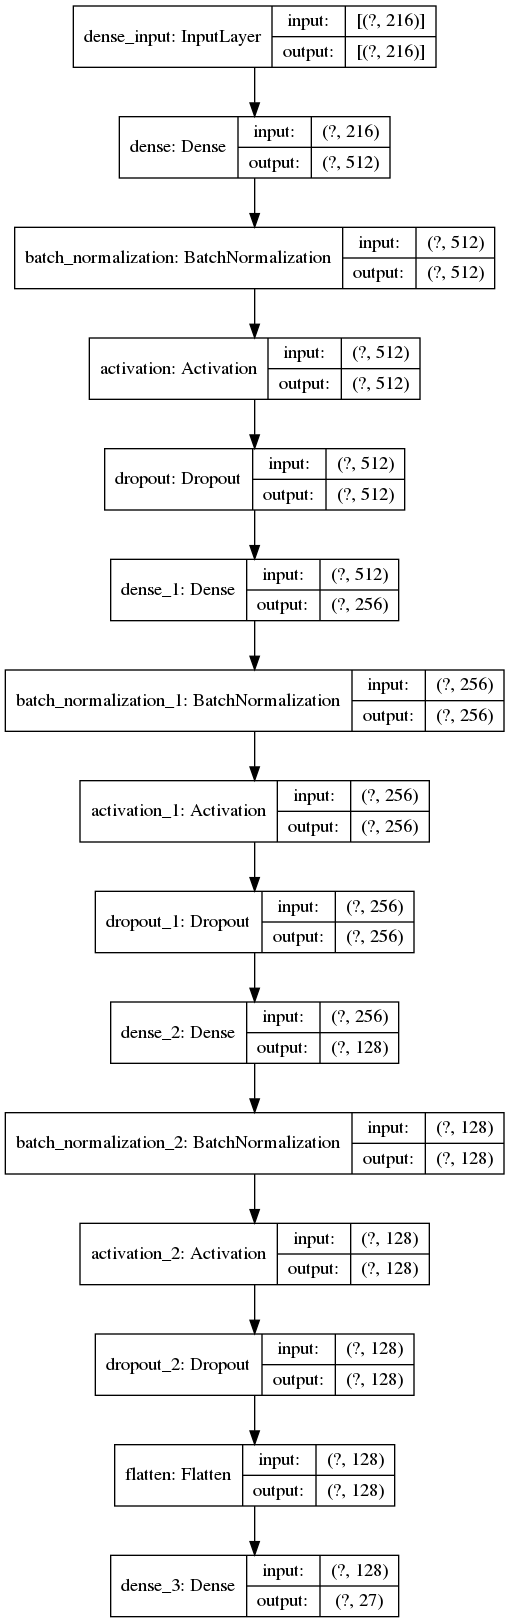

In [10]:
sequence_length = 8
vocab_size, embedding_size = (27, 20)

K.clear_session()

layer_size = 128

# embeddings = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=sequence_length)(input)
model = Sequential()
# model.add(Embedding(vocab_size, embedding_size,
#                          input_length=sequence_length))

model.add(Dense(512, input_dim=vocab_size*sequence_length))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(vocab_size, "relu"))
tag = "basic_nn"

plot_model(model, show_shapes = True)

In [ ]:
training_params = {
    'loss': f1_loss,
    'optimizer': 'rmsprop',
    'metrics': [f1],
    'run_eagerly': False
}

model.compile(**training_params)

epochs=200

folder = create_training_folder("papers",tag)

lr_scheduller = tf.keras.callbacks.LearningRateScheduler(step_decay_exp)
#lr_scheduller = tf.keras.callbacks.ReduceLROnPlateau(step_decay_exp)
lr_scheduller = None
callbacks = create_callbacks(folder, tensor_board=True, monitor_metric="val_f1", monitor_mode="max",
                     lr_scheduller=lr_scheduller)


train(model, X_train, y_train, X_test, y_test, epochs=epochs, callbacks=callbacks)

# save model
model_folder = '{}/model'.format(folder)
model.save(model_folder)


Epoch 1/200

Epoch 00001: val_f1 improved from -inf to 0.58850, saving model to /home/gus/workspaces/wpy/IACapstone/results/papers/20200801_091118_basic_nn
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/papers/20200801_091118_basic_nn/assets
687/687 - 4s - loss: 0.5524 - f1: 0.4498 - val_loss: 0.4095 - val_f1: 0.5885
Epoch 2/200

Epoch 00002: val_f1 improved from 0.58850 to 0.63249, saving model to /home/gus/workspaces/wpy/IACapstone/results/papers/20200801_091118_basic_nn
INFO:tensorflow:Assets written to: /home/gus/workspaces/wpy/IACapstone/results/papers/20200801_091118_basic_nn/assets
687/687 - 4s - loss: 0.3951 - f1: 0.6052 - val_loss: 0.3657 - val_f1: 0.6325
Epoch 3/200

Epoch 00003: val_f1 improved from 0.63249 to 0.65638, saving model to /home/gus/workspaces/wpy/IACapstone/results/papers/20200801_091118_basic_nn
INFO:tensorflow:Assets written to: /home/gus/workspaces

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from recipes import plot_confusion_matrix

y_pred = model.predict(X_test)

class_test = np.argmax(y_test, axis=1)
class_predicted = np.argmax(y_pred, axis=1)

crop_names = df_crops["description"].values.tolist()
crop_list = df_crops["idx"].values.tolist()

classes = crop_list
cfm = confusion_matrix(class_test, class_predicted, classes)
# plot_confusion_matrix(cfm, classes=crop_names, figsize=(20, 20), output_file="{}/cfm.png".format(folder))
plot_confusion_matrix(cfm, figsize=(20, 20), classes=crop_names)#, classes= crop_names)
